## News Mood

#### Import dependencies. Initialize sentiment analyzer. Twitter API keys and authentication

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target User Account
target_users = ("@BBCWorld","@CBSNews","@CNN","@FoxNews","@nytimes")
                
# Variables for holding tweets and sentiments
tweet_user = []
tweet_texts = []
created_times =[]
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
converted_timestamp =[]
time_diffs = []

# Loop through each user
for target_user in target_users:
    
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(1, 6):
        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=x) 
        # Loop through all tweets
        raw_times=[]
        for tweet in public_tweets:
    
            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])

            # Add each value to the appropriate list
            tweet_texts.append(tweet["text"])
            tweet_user.append(tweet['user']['name'])
            created_times.append(tweet["created_at"]) 
            raw_times.append(tweet["created_at"]) 
            compound_list.append(results['compound'])
            positive_list.append(results['pos'])
            negative_list.append(results['neg'])
            neutral_list.append(results['neu'])
            
        #convert string times to date objects
        converted_times =[]
        for raw_time in raw_times:
            converted_time = datetime.strptime(raw_time,"%a %b %d %H:%M:%S %z %Y") #string is formatted as""%a %b %d %H:%M:%S %z %Y" so convert it into date time object
            converted_times.append(converted_time)
            converted_timestamp.append(converted_time)
         
        converted_length = len(converted_times)

        #find the difference between tweets
        time_diffs.append(0)
        for x in range(converted_length - 1):
            time_diff = converted_times [x] - converted_times[x+1]

            # convert time_diff to minutes
            time_diff = time_diff.seconds / 60
            time_diffs.append(time_diff)
            

In [3]:
#Create dataframe
tweet_pd = pd.DataFrame({"Tweets" : tweet_texts,"Compound Score":compound_list,
                          "Positive Score":positive_list,"Negative Score":negative_list,"Neutral Score":neutral_list,
                          "Created Date":created_times, "Tweeter Account":tweet_user,
                          "Time Between Tweets (in minutes)":time_diffs,"Converted Time":converted_timestamp})

tweet_pd.head()

,Compound Score,Converted Time,Created Date,Negative Score,Neutral Score,Positive Score,Time Between Tweets (in minutes),Tweeter Account,Tweets
0,0.0000,2018-06-06 23:38:56+00:00,Wed Jun 06 23:38:56 +0000 2018,0.000,1.000,0.000,0.000000,BBC News (World),Separation of migrant families: What other cou...
1,0.6597,2018-06-06 23:33:41+00:00,Wed Jun 06 23:33:41 +0000 2018,0.000,0.597,0.403,5.250000,BBC News (World),Meet the nuns helping save a sacred species fr...
2,-0.1796,2018-06-06 23:33:40+00:00,Wed Jun 06 23:33:40 +0000 2018,0.241,0.568,0.191,0.016667,BBC News (World),G7 summit: Trapped in the world's most secure ...
3,0.0000,2018-06-06 23:33:40+00:00,Wed Jun 06 23:33:40 +0000 2018,0.000,1.000,0.000,0.000000,BBC News (World),A North Korean wishlist: The three things Pyon...
4,-0.4404,2018-06-06 23:17:39+00:00,Wed Jun 06 23:17:39 +0000 2018,0.281,0.576,0.144,16.016667,BBC News (World),Ethiopia offers Eritrea chance to end Africa's...


In [4]:
#Create a dataframe for each Tweeter Account
BBC = tweet_pd[tweet_pd["Tweeter Account"] == 'BBC News (World)']
CBS = tweet_pd[tweet_pd["Tweeter Account"] == 'CBS News']
CNN = tweet_pd[tweet_pd["Tweeter Account"] == 'CNN']
FOX = tweet_pd[tweet_pd["Tweeter Account"] == 'Fox News']
NYTimes = tweet_pd[tweet_pd["Tweeter Account"] == 'The New York Times']

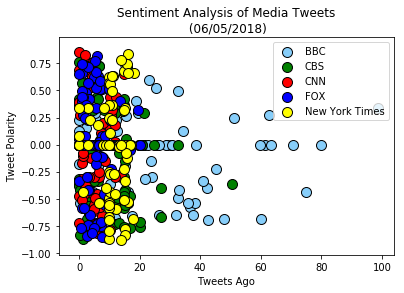

In [8]:
#Scatter plot
plt.scatter(BBC["Time Between Tweets (in minutes)"], BBC["Compound Score"],facecolors="lightskyblue",label="BBC",edgecolors="black", marker = "o",s=100)
plt.scatter(CBS["Time Between Tweets (in minutes)"], CBS["Compound Score"],facecolors="green",label="CBS",edgecolors="black", marker = "o",s=100)
plt.scatter(CNN["Time Between Tweets (in minutes)"], CNN["Compound Score"],facecolors="red",label="CNN",edgecolors="black", marker = "o",s=100)
plt.scatter(FOX["Time Between Tweets (in minutes)"], FOX["Compound Score"],facecolors="blue",label="FOX",edgecolors="black", marker = "o",s=100)
plt.scatter(NYTimes["Time Between Tweets (in minutes)"], NYTimes["Compound Score"],facecolors="yellow",label="New York Times",edgecolors="black", marker = "o",s=100)

#plt.xlim(70,-5)
#plt.ylim (-1.5,1.5)
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
plt.title("Sentiment Analysis of Media Tweets\n (06/05/2018)")
plt.legend (loc = "upper right")
plt.show()

plt.savefig("MediaSentimentAnalysis.png")

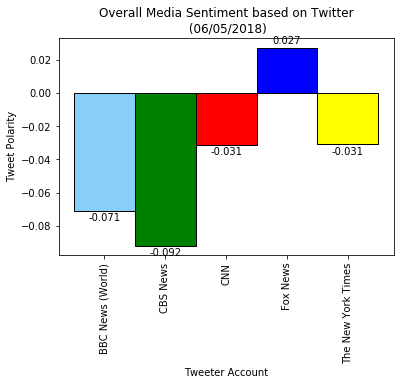

In [9]:
#Overall Media Sentiment bar graph

media_group = tweet_pd.groupby('Tweeter Account')
average_compound = media_group['Compound Score'].mean()

average_chart = average_compound.plot(kind='bar',width=1,edgecolor = "black",
                                     color=["lightskyblue","green","red","blue","yellow"])

plt.ylabel("Tweet Polarity")
plt.title("Overall Media Sentiment based on Twitter\n (06/05/2018)")

#Create data value labels for bars
rects = average_chart.patches

for rect in rects:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 2
    va = 'bottom'
    
    if y_value < 0:
        space *= -1
        va = 'top'  

    label = "{:.3f}".format(y_value)
    
    plt.annotate(label,            
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)                      

plt.show()
plt.savefig("OverallMediaAnalysis.png")

In [10]:
#Create clean dataframe for export to csv
media_tweet_pd = pd.DataFrame({"Tweets" : tweet_texts,"Compound Score":compound_list,
                          "Positive Score":positive_list,"Negative Score":negative_list,"Neutral Score":neutral_list,
                          "Created Date":created_times, "Tweeter Account":tweet_user})

#format
media_tweet_pd["Compound Score"] = media_tweet_pd["Compound Score"].map("{:,.2f}".format) 
media_tweet_pd["Negative Score"] = media_tweet_pd["Negative Score"].map("{:,.2f}".format) 
media_tweet_pd["Positive Score"] = media_tweet_pd["Positive Score"].map("{:,.2f}".format) 
media_tweet_pd["Neutral Score"] = media_tweet_pd["Neutral Score"].map("{:,.2f}".format) 

media_tweet_pd = media_tweet_pd[["Tweeter Account","Tweets","Created Date","Compound Score","Positive Score","Negative Score","Neutral Score"]]

media_tweet_pd.head()

media_tweet_pd.to_csv("NewsMood.csv",index=False,header=True)

## Observations
1. Minutes between tweets for BBC is greater than the other media outlets. May be duee the time difference.
2. Most of the CBS tweets are within the 20 minute window, but also very negative.
3. Though the media should be neutral, the Overall Media Sentiment proves otherwise.